In [1]:
import os
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

import geemap

from geeml.utils import eeprint

In [2]:
import ee
service_account = 'github-action@ee-geethensingh.iam.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, r"C:\Users\coach\myfiles\postdoc\Fire\code\secret.json")
ee.Initialize(credentials)

In [3]:
os.chdir(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components")
os.getcwd()

'C:\\Users\\coach\\myfiles\\postdoc\\Fire\\code\\Burn_Area_Mapping\\src\\components'

In [4]:
from data_extraction import extractDataset
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:

Map = geemap.Map()
fc = ee.FeatureCollection("projects/ee-geethensingh/assets/postdoc/proj_fired_south_africa_to2021182_events")
Map.addLayer(ee.Feature(fc.first()), {'color': 'red'}, "Fire Test")
Map.centerObject(fc.first(), 12)
Map

Map(center=[-31.374999751707104, 29.510986261502627], controls=(WidgetControl(options=['position', 'transparen…

## Step 1: Data extraction

In [7]:
# Filter fire events to period and area of interest
fireEvents = fc.map(lambda ft: ft.set('system:time_start', ee.Date(ft.get('ig_date')))
                    .set('system:time_end', ee.Date(ft.get('last_date')))).filterDate('2019-01-01', '2020-01-01')

In [8]:
# Get Landsat-8 features for South Africa
extractDataset('LANDSAT_8', 'South Africa', ee.Date('2019-09-01'), ee.Date('2020-01-01'), fireEvents, 16, 'extract_20190912.csv')

  0%|          | 0/572 [00:00<?, ?it/s]

## Step 2: train and eval

In [7]:
from data_ingestion import dataIngestion
from data_transformation import dataTransformation
from model_trainer import modelTrainer

Naive Baseline Accuracy: 0.74
No best model found, metric < 0.6


    You can remove it from Git, then add to DVC.
        To stop tracking from Git:
            git rm -r --cached 'artifacts'
            git commit -m "stop tracking artifacts" 


classification report               precision    recall  f1-score   support

         0.0       0.79      0.93      0.86       206
         1.0       0.59      0.28      0.38        71

    accuracy                           0.77       277
   macro avg       0.69      0.61      0.62       277
weighted avg       0.74      0.77      0.73       277

Confusion Matrix:


0.380952380952381

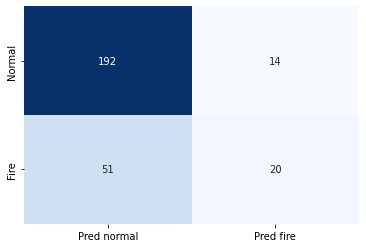

In [8]:
obj = dataIngestion()
train_path, calibration_path, test_path = obj.initiate_data_ingestion()
data_transformation = dataTransformation()
train_arr, cal_arr, test_arr = data_transformation.initiate_data_transformation(train_path, calibration_path, test_path)

model_trainer = modelTrainer()
model_trainer.initiate_model_trainer(train_arr, cal_arr, test_arr)

## Step 3: Inference

In [21]:
from src.utils import load_object
import pandas as pd

from mapie.classification import MapieClassifier

# model = load_object(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\model.pkl")
df = pd.read_csv(r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\train.csv")


X_train = df.drop(['scenes', 'label'], axis=1)
y_train = df[['label']]

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state= 42, verbose= False).fit(X_train, y_train)
print(model.predict(dfPredict))

mapie_score = MapieClassifier(estimator = model, cv="prefit", method="lac", random_state= 42)
mapie_score.fit(X_train, y_train)
mapie_score.predict(dfPredict, alpha =0.05)

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]


(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 array([[[ True],
         [False]],
 
        [[F

In [25]:
from inference import Inference

inference_pipeline = Inference()
sceneList = inference_pipeline.initiate_inference_pipeline('LANDSAT_8', 'South Africa')
sceneList

Number of new scenes: 55
input dates 2024-03-01 2024-04-02


  0%|          | 0/55 [00:00<?, ?it/s]

0    2_LC08_160092_20240310
0    2_LC08_167079_20240311
0    2_LC08_167080_20240311
0    2_LC08_168077_20240302
0    2_LC08_168078_20240302
0    2_LC08_168080_20240302
0    2_LC08_168081_20240302
0    2_LC08_168082_20240302
0    2_LC08_169075_20240309
0    2_LC08_169078_20240309
0    2_LC08_169079_20240309
0    2_LC08_169080_20240309
0    2_LC08_169082_20240309
0    2_LC08_171076_20240307
0    2_LC08_171078_20240307
0    2_LC08_171079_20240307
0    2_LC08_171080_20240307
0    2_LC08_171081_20240307
0    2_LC08_171082_20240307
0    2_LC08_173077_20240305
0    2_LC08_173078_20240305
0    2_LC08_173079_20240305
0    2_LC08_173080_20240305
0    2_LC08_173081_20240305
0    2_LC08_173082_20240305
0    2_LC08_175077_20240303
0    2_LC08_175078_20240303
0    2_LC08_175082_20240303
0    2_LC08_176077_20240310
0    2_LC08_176078_20240310
0    2_LC08_177081_20240301
Name: scenes, dtype: object

In [43]:
# Example usage:
# Delete logs older than March 1, 2024
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping', datetime.datetime(2024, 3, 11))
# Or, delete logs older than one month (default behavior)
delete_old_logs(r'C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping')

Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_14_13_35.log\03_06_2024_14_13_35.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_06_2024_23_25_28.log\03_06_2024_23_25_28.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_09_11_34.log\03_07_2024_09_11_34.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_07_2024_20_08_47.log\03_07_2024_20_08_47.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_09_41_30.log\03_08_2024_09_41_30.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_15_57.log\03_08_2024_10_15_57.log
Deleted file: C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\logs\03_08_2024_10_19_03.log\03_08_2024_10_19_03.log
Deleted file: